## Import 

In [1]:
import matplotlib.pyplot as plt
import pathlib
import rich
import numpy as np
import pandas as pd

opts = {
    'display.max_columns': None,
    'display.max_colwidth': 50,
    'display.expand_frame_repr': False,  # Don't wrap to multiple pages
    'display.max_rows': 999, # maximum number of rows pandas should output 
    'display.max_seq_items': 50,         # Max length of printed sequence
    'display.precision': 4, # Floating point output precision
    'display.show_dimensions': True,
    'display.width':200, # Width of the display in characters. in a terminal this can be set to None, not in notebook or qtconsole.
    }

# set pandas options
[pd.set_option(n,o) for n,o in opts.items()]

# useful for displaying html, images and so on
from IPython.display import display

import geopandas as gpd

## MASCS Data

### direct osgeo/gdal read

In [2]:
from osgeo import ogr
import geopandas as gpd
import pandas as pd
import shapely
# useful for displaying html, images and so on
from IPython.display import display

In [3]:
file = "../data/raw/test/mess-e_v_h-mascs-3-virs-cdr-caldata-v1/messmas_2101/data/ddr/orb/virs/mascs20110812/vis/virsvd_orb_11224_214005.lbl"

In [4]:
df = gpd.read_file(file,engine='fiona').drop(columns=['SPARE_1', 'SPARE_2', 'SPARE_3','SPARE_4', 'SPARE_5',]) # default engine, no warnings

In [5]:
# convert SPECTRUM_UTC_TIME to python datetime object 
from datetime import datetime
df['SPECTRUM_UTC_TIME'] = pd.to_datetime(df['SPECTRUM_UTC_TIME'].map(lambda x : datetime.strptime(x.strip(), '%y%jT%H:%M:%S')))

In [6]:
df.iloc[[0,-1]].T

,0,420
SC_TIME,221672673.0,221673198.0
PACKET_SUBSECONDS,47,50
INT_TIME,20,20
INT_COUNT,421,421
DARK_FREQ,40,40
TEMP_2,26.901,29.541
BINNING,1,1
START_PIXEL,0,0
END_PIXEL,361,361
SPECTRUM_NUMBER,0,420


In [7]:
# drop the index in a column
df.index.name = 'pid' # primary ID
df = df.reset_index(drop=0)

In [8]:
inDataSource = ogr.Open(file)
table = inDataSource.GetLayer()

In [9]:
TARGET_LONGITUDE_SET = np.array([t.GetField('TARGET_LONGITUDE_SET') for t in table])
TARGET_LATITUDE_SET  = np.array([t.GetField('TARGET_LATITUDE_SET') for t in table])
stacked_latlon = np.stack((TARGET_LONGITUDE_SET,TARGET_LATITUDE_SET))
print(f'{TARGET_LATITUDE_SET.shape=}')
print(f'{TARGET_LONGITUDE_SET.shape=}')
print(f'{stacked_latlon.shape=}')

TARGET_LATITUDE_SET.shape=(421, 5)
TARGET_LONGITUDE_SET.shape=(421, 5)
stacked_latlon.shape=(2, 421, 5)


In [10]:
# this select only the polygons c1,c3,c2,c4 in this order, see Fig.4 in VIRS_CDRSIS.PDF
corners_index = [1,3,2,4]
coordinates = np.moveaxis(stacked_latlon[:,:,corners_index].T,1,0)
polygon_list = [shapely.geometry.Polygon(p)  for p in  coordinates]

In [11]:
corners_index = 0
points_list = [shapely.geometry.Point(p)  for p in  stacked_latlon[:,:,corners_index].T]

## SPICE kernels use


In [12]:
import spiceypy

In [13]:
kernels_basepath = pathlib.Path().resolve() / '../data/raw/spice_kernels/NASA/messsp_1000/data'
# kernels_basepath = pathlib.Path('/home/kidpixo/Documents/work/MESSENGER/MASCS_mda_dlr_processed/spice_kernels_messenger/data')

print(f'{kernels_basepath=}')
print(f'{kernels_basepath.exists()=}')

kernels_basepath=PosixPath('/home/kidpixo/Documents/work/ISSI_Galliano/code/MESSENGER-MASCS-VIRS-geometry-calculator/notebooks/../data/raw/spice_kernels/NASA/messsp_1000/data')
kernels_basepath.exists()=True


In [14]:
# symlink SPICE path to /tmp/spice_kernels_messenger > SPICE Paths are limited to 255 chars!!!! 
original_spice_dir = pathlib.Path(kernels_basepath)

spice_dir = pathlib.Path('/tmp/spice_kernels_messenger')

if not spice_dir.exists():
    spice_dir.symlink_to(original_spice_dir)

In [15]:
# symlink SPICE path to /tmp/spice_kernels_messenger > SPICE Paths are limited to 255 chars!!!! 
esa_dsk_path = pathlib.Path('').resolve() / '../data/raw/spice_kernels/ESA/kernels/dsk'

new_dsk_path = original_spice_dir / 'dsk' 

if not new_dsk_path.exists():
    new_dsk_path.symlink_to(esa_dsk_path)

In [16]:
spiceypy.kclear()# Clear the Spice kernels pool

In [17]:
metakernels_paths = list(pathlib.Path(kernels_basepath / '../..').glob('*tm'))
# metakernels_paths = list(pathlib.Path(kernels_basepath / '../extras/mk_mod').glob('*tm'))
metakernels_paths_dict = {p.stem.split('_')[1]:p for p in metakernels_paths}
metakernels_paths_dict

{'2011': PosixPath('/home/kidpixo/Documents/work/ISSI_Galliano/code/MESSENGER-MASCS-VIRS-geometry-calculator/notebooks/../data/raw/spice_kernels/NASA/messsp_1000/data/../../msgr_2011_v10_110812_110812.tm')}

In [18]:
print(f'Data year of aquisition : {df["SPECTRUM_UTC_TIME"].dt.year.unique()[0]}')

Data year of aquisition : 2011


In [19]:
# # subset metakernel
# spiceypy.furnsh(str(kernels_basepath / 'msgr_2011_v10_110812_110812.tm'))  # load the kernel in the pool

# mission metakernel
spiceypy.furnsh(str(metakernels_paths_dict['2011']))  # load the kernels

In [20]:
sensor = 'MSGR_MASCS_VIRS'
sensor_id = spiceypy.bodn2c(sensor)
target = 'MERCURY'
tarid = spiceypy.bodn2c(target)

n, radii = spiceypy.bodvrd(target, 'RADII', 3)
re = radii[0]
rp = radii[2]
radii_relative_difference = (re - rp) / re # radii relative difference

rich.print({
    'sensor':sensor,
    'sensor_id':sensor_id,
    'target':target,
    'tarid':tarid,
    'n':n,
    'radii': radii,
    'radius equ.' : re,
    'radius pol.' : rp,
    'radii_relative_difference': radii_relative_difference
})

{
    'sensor': 'MSGR_MASCS_VIRS',
    'sensor_id': -236620,
    'target': 'MERCURY',
    'tarid': 199,
    'n': 3,
    'radii': array([2439.4, 2439.4, 2439.4]),
    'radius equ.': 2439.4,
    'radius pol.': 2439.4,
    'radii_relative_difference': 0.0
}

If the value of `shape` is "CIRCLE" the field of view of
the instrument is a circular cone centered on the
boresight vector. 

The vertex of the cone is at the instrument focal point.

A single vector will be returned in `bounds`.

This vector will be parallel to a ray that lies in the cone that makes up the boundary
of the field of view.


In [21]:
(shape, sensor_frame, bsight, vectors, bounds) = spiceypy.getfov(sensor_id,20)

In [22]:
rich.print({
    'shape':shape,
    'sensor_frame':sensor_frame,
    'bsight':bsight,
    'vectors':vectors,
    'bounds':bounds,
})

{
    'shape': 'CIRCLE',
    'sensor_frame': 'MSGR_MASCS_VIRS',
    'bsight': array([0., 0., 1.]),
    'vectors': 1,
    'bounds': array([[2.00712863e-04, 0.00000000e+00, 9.99999980e-01]])
}

In [23]:
bound_norm = bounds[0]/spiceypy.spiceypy.unorm(bounds[0])[1]

In [24]:
# rotate bounds vector

# angular step in deg
steps = 12*10
angle_step = 360/steps
print(f'{steps=}')
print(f'{angle_step=}')
angle_step = 360//steps

steps=120
angle_step=3.0


In [25]:
# # print FOV steps
# for a in range(0,steps):
#     print(f'{a:2d} {angle_step*(a):3d}',spiceypy.vrotv([1,0,0],bsight, np.deg2rad(angle_step*(a))) )  

Text(0.5, 1.0, 'MASCS VIS Istantaneous Field of View (iFOV) approximated as 120 points')

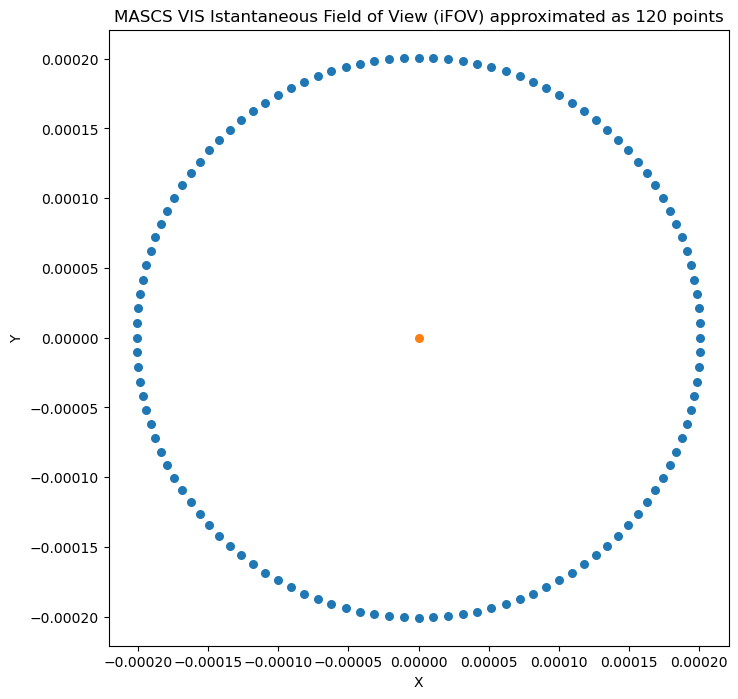

In [26]:
plt.figure(figsize=[8,8])

fov_points = np.asarray([spiceypy.vrotv(bound_norm, bsight, np.deg2rad(angle_step*(a))) for a in range(0,steps)])

plt.scatter(fov_points[:,0],fov_points[:,1],s=30)
plt.scatter(0,0,s=30)

plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'MASCS VIS Istantaneous Field of View (iFOV) approximated as {steps} points')

In [27]:
observer = 'MESSENGER'
target_frame = 'IAU_MERCURY'

In [28]:
et = spiceypy.utc2et('2011-08-12 21:42:15')       # Convert the UTC datetime in Ephemris Time (ET)
rich.print(
{'computation method':'ELLIPSOID',
'target':target,
'et':et,
'target body frame':target_frame,
'aberration correction':'LT+S',
'observing body':observer,
'sensor_frame':sensor_frame,
})

{
    'computation method': 'ELLIPSOID',
    'target': 'MERCURY',
    'et': 366457401.18299663,
    'target body frame': 'IAU_MERCURY',
    'aberration correction': 'LT+S',
    'observing body': 'MESSENGER',
    'sensor_frame': 'MSGR_MASCS_VIRS'
}

In [29]:
# method = 'ELLIPSOID'
method = 'DSK/UNPRIORITIZED/SURFACES = \"199\"'
aberration_correction='LT+S'

In [30]:
# rich.print(geometry_intersect(method,target,et,target_frame, aberration_correction,observer,sensor_frame,bsight) )

In [31]:
from msgmascsgeo import spicefuncs

In [32]:
# calculate the Ephemeris Time (ET)
spacecraft_id = spiceypy.bodn2c('MESSENGER')
df['ET'] = df.apply(lambda x : spiceypy.scs2e(spacecraft_id,str(x.SPECTRUM_MET+x.SPECTRUM_SUBSECONDS/1000)) ,axis=1)

In [33]:
gdf_pds_poly  = gpd.GeoDataFrame(data=df.copy() ,geometry=polygon_list)
gdf_pds_point = gpd.GeoDataFrame(data=df.copy(),geometry= points_list)

<Axes: >

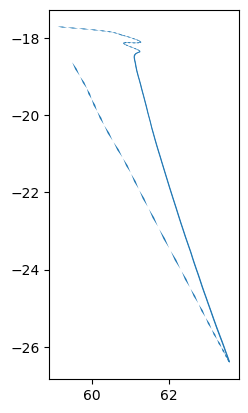

In [34]:
gdf_pds_poly.plot()

<Axes: >

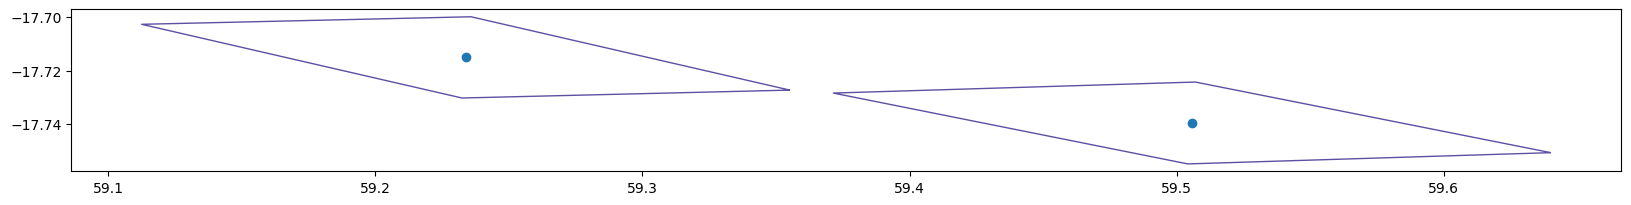

In [35]:
ax = gdf_pds_poly.head(2).plot(figsize=[20,8],facecolor='none',column='SC_TIME',cmap=plt.cm.Spectral_r)
gdf_pds_point.head(2).plot(ax=ax)

In [36]:
(method,
target,
spiceypy.utc2et(str(df.loc[200,'SPECTRUM_UTC_TIME'])),
df.loc[200,'pid'],
target_frame,
aberration_correction,
observer,
sensor_frame,
radii,
tarid,
bsight)

('DSK/UNPRIORITIZED/SURFACES = "199"',
 'MERCURY',
 366457522.1829966,
 200,
 'IAU_MERCURY',
 'LT+S',
 'MESSENGER',
 'MSGR_MASCS_VIRS',
 array([2439.4, 2439.4, 2439.4]),
 199,
 array([0., 0., 1.]))

In [39]:
# 1 fov point for fixed times 
spicefuncs.geometry_intersect(
                    method,
                    target,
                    spiceypy.utc2et(str(df.loc[200,'SPECTRUM_UTC_TIME'])),
                    df.loc[200,'pid'],
                    target_frame,
                    aberration_correction,
                    observer,
                    sensor_frame,
                    radii,
                    tarid,
                    bsight)

{'method': 'DSK/UNPRIORITIZED/SURFACES = "199"',
 'et': 366457522.1829966,
 'pid': 200,
 'spoint': array([1059.23837896, 1997.67143337, -915.63215834]),
 'trgepc': 366457522.16719073,
 'srfvec': array([  832.96708578, -2530.65139567,  2109.52463544]),
 'tarlon': 62.065830901248404,
 'tarlat': -22.04527755259405,
 'taralt': 0.07931914625473468,
 'tardis': 3398.2532515850585,
 'tarang ': 93.3701127884854,
 'trgenpc': 366457522.1716612,
 'phase': 77.85278417897125,
 'incdnc': 34.870795067570675,
 'emissn': 42.98983078491956,
 'visiblef': True,
 'iluminatedf': True,
 'hr': 13,
 'mn': 53,
 'sc': 12,
 'ltime': '13:53:12',
 'ampm': '01:53:12 P.M.',
 'sublon': 87.14059231909094,
 'sublat': -33.71241193084964,
 'subalt': -2.246736831372798,
 'srfev': array([ 1801.73620697, -3172.46877209,  3023.62103653]),
 'sunlon': 33.76234446979182,
 'sunlat': -0.033349787346125814,
 'sunalt': 0.14119952827096688}

In [40]:
# fov points for fixed times
points_df = pd.DataFrame.from_dict([
    spicefuncs.geometry_intersect(
                    method,
                    target,
                    spiceypy.utc2et(str(df.loc[200,'SPECTRUM_UTC_TIME'])),
                    df.loc[200,'pid'],
                    target_frame,
                    aberration_correction,
                    observer,
                    sensor_frame,
                    radii,
                    tarid,
                    bsight) for v in fov_points] )
# points_df.T

In [41]:
from tqdm.notebook import trange, tqdm
from tqdm.gui import tqdm as tqdm_gui

tqdm.pandas()  # can use tqdm_gui, optional kwargs, etc

In [42]:
# calculate for all measurements in orbit at spectrum_utc_time (vector)
to_fovs_df = gdf_pds_poly.iloc[5:40]
print(to_fovs_df.shape)

(35, 24)


<Axes: >

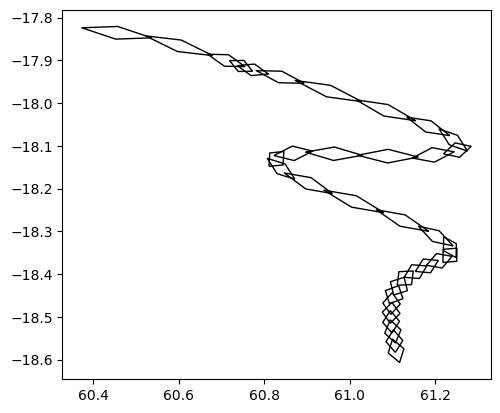

In [43]:
to_fovs_df.plot(facecolor='none')

In [44]:
import functools

In [45]:
spicefuncs.row_to_shape(  to_fovs_df.iloc[0],
                          starting_fovs_n=5,
                          radii=radii,
                          tarid=tarid,
                          fov_points=fov_points, 
                          method=method,
                          target=target,
                          target_frame=target_frame,
                          aberration_correction=aberration_correction,
                          observer=observer,
                          sensor_frame=sensor_frame)

,time_steps,fov,std_trgepc,std_tarlon,std_tarlat,std_taralt,std_tardis,std_tarang,std_trgenpc,std_phase,std_incdnc,std_emissn,std_hr,std_mn,std_sc,std_sublon,std_sublat,std_subalt,std_sunlon,std_sunlat,std_sunalt,mean_trgepc,mean_tarlon,mean_tarlat,mean_taralt,mean_tardis,mean_tarang,mean_trgenpc,mean_phase,mean_incdnc,mean_emissn,mean_hr,mean_mn,mean_sc,mean_sublon,mean_sublat,mean_subalt,mean_sunlon,mean_sunlat,mean_sunalt
pid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,0.00,POLYGON ((60.33496780942908 -17.80568666151769...,5.9855e-08,0.0146,0.0116,0.0048,0.4578,0.0318,1.5300e-06,0.0082,4.3768e-02,0.0386,0.0,0.0,3.5551,1.4270e-14,0.0000e+00,0.0000e+00,0.0000e+00,6.9680e-18,5.5744e-17,3.6646e+08,60.3272,-17.8182,0.4336,3076.2068,94.4421,3.6646e+08,78.1412,31.8959,46.2518,13.0,46.0,13.1583,86.3312,-28.5557,-0.2876,33.7703,-0.0334,0.1456
5,0.25,POLYGON ((60.36884948471309 -17.81000464364486...,0.0000e+00,0.0146,0.0116,0.0036,0.4587,0.0318,1.5318e-06,0.0082,4.8606e-07,0.0082,0.0,0.0,3.5254,0.0000e+00,1.0703e-14,1.1149e-16,7.1352e-15,6.9680e-18,2.7872e-17,3.6646e+08,60.3611,-17.8225,0.4241,3075.7185,94.4984,3.6646e+08,78.1263,31.8318,46.3016,13.0,46.0,21.2583,86.3321,-28.5614,-0.2892,33.7703,-0.0334,0.1456
5,0.50,POLYGON ((60.402729680411774 -17.8143246331583...,1.1971e-07,0.0146,0.0116,0.0033,0.4585,0.0318,1.5299e-06,0.0082,2.7933e-02,0.0229,0.0,0.0,3.4730,2.8541e-14,1.0703e-14,0.0000e+00,7.1352e-15,1.3936e-17,0.0000e+00,3.6646e+08,60.3950,-17.8268,0.4166,3075.2293,94.5548,3.6646e+08,78.1115,31.8169,46.3014,13.0,46.0,29.4250,86.3329,-28.5670,-0.2909,33.7703,-0.0334,0.1456
5,0.75,POLYGON ((60.436610007349636 -17.8186475690937...,5.9855e-08,0.0146,0.0116,0.0028,0.4589,0.0319,1.5329e-06,0.0082,3.1331e-02,0.0250,0.0,0.0,3.4467,2.8541e-14,7.1352e-15,5.5744e-17,0.0000e+00,6.9680e-18,5.5744e-17,3.6646e+08,60.4289,-17.8311,0.4104,3074.7399,94.6112,3.6646e+08,78.0966,31.7869,46.3161,13.0,46.0,37.5500,86.3338,-28.5727,-0.2925,33.7703,-0.0334,0.1456
5,1.00,POLYGON ((60.47048837078595 -17.82298081287918...,0.0000e+00,0.0146,0.0116,0.0026,0.4588,0.0319,1.5311e-06,0.0082,4.8637e-07,0.0082,0.0,0.0,3.5241,2.8541e-14,1.0703e-14,0.0000e+00,7.1352e-15,0.0000e+00,2.7872e-17,3.6646e+08,60.4627,-17.8355,0.4056,3074.2507,94.6677,3.6646e+08,78.0817,31.7653,46.3225,13.0,46.0,45.7250,86.3346,-28.5784,-0.2941,33.7703,-0.0334,0.1456


In [46]:
ifovs_df = pd.concat(to_fovs_df.reset_index().progress_apply(functools.partial(spicefuncs.row_to_shape,
                                                                              starting_fovs_n=5,
                                                                              radii=radii,
                                                                              tarid=tarid,
                                                                              fov_points=fov_points, 
                                                                              method=method,
                                                                              target=target,
                                                                              target_frame=target_frame,
                                                                              aberration_correction=aberration_correction,
                                                                              observer=observer,
                                                                              sensor_frame=sensor_frame,)
                                                            ,axis=1).values)

  0%|          | 0/35 [00:00<?, ?it/s]

In [47]:
# convert iFOVS to Geopandas.GeoDataFrame
geofovs_df = gpd.GeoDataFrame(ifovs_df.reset_index(drop=0), geometry='fov')
# iFOVS unary_union.convex_hull : size == initial size, one geometry per measurement
geounion_gdf = gpd.GeoDataFrame(
    geofovs_df.drop(columns=['fov']).groupby('pid').agg(np.median),             # group per PID and average
    geometry=[v.unary_union.convex_hull for k,v in geofovs_df.groupby('pid')]# assemble union geometry
).reset_index(drop=0)

In [48]:
geofovs_df.columns

Index(['pid', 'time_steps', 'fov', 'std_trgepc', 'std_tarlon', 'std_tarlat', 'std_taralt', 'std_tardis', 'std_tarang ', 'std_trgenpc', 'std_phase', 'std_incdnc', 'std_emissn', 'std_hr', 'std_mn',
       'std_sc', 'std_sublon', 'std_sublat', 'std_subalt', 'std_sunlon', 'std_sunlat', 'std_sunalt', 'mean_trgepc', 'mean_tarlon', 'mean_tarlat', 'mean_taralt', 'mean_tardis', 'mean_tarang ',
       'mean_trgenpc', 'mean_phase', 'mean_incdnc', 'mean_emissn', 'mean_hr', 'mean_mn', 'mean_sc', 'mean_sublon', 'mean_sublat', 'mean_subalt', 'mean_sunlon', 'mean_sunlat', 'mean_sunalt'],
      dtype='object')

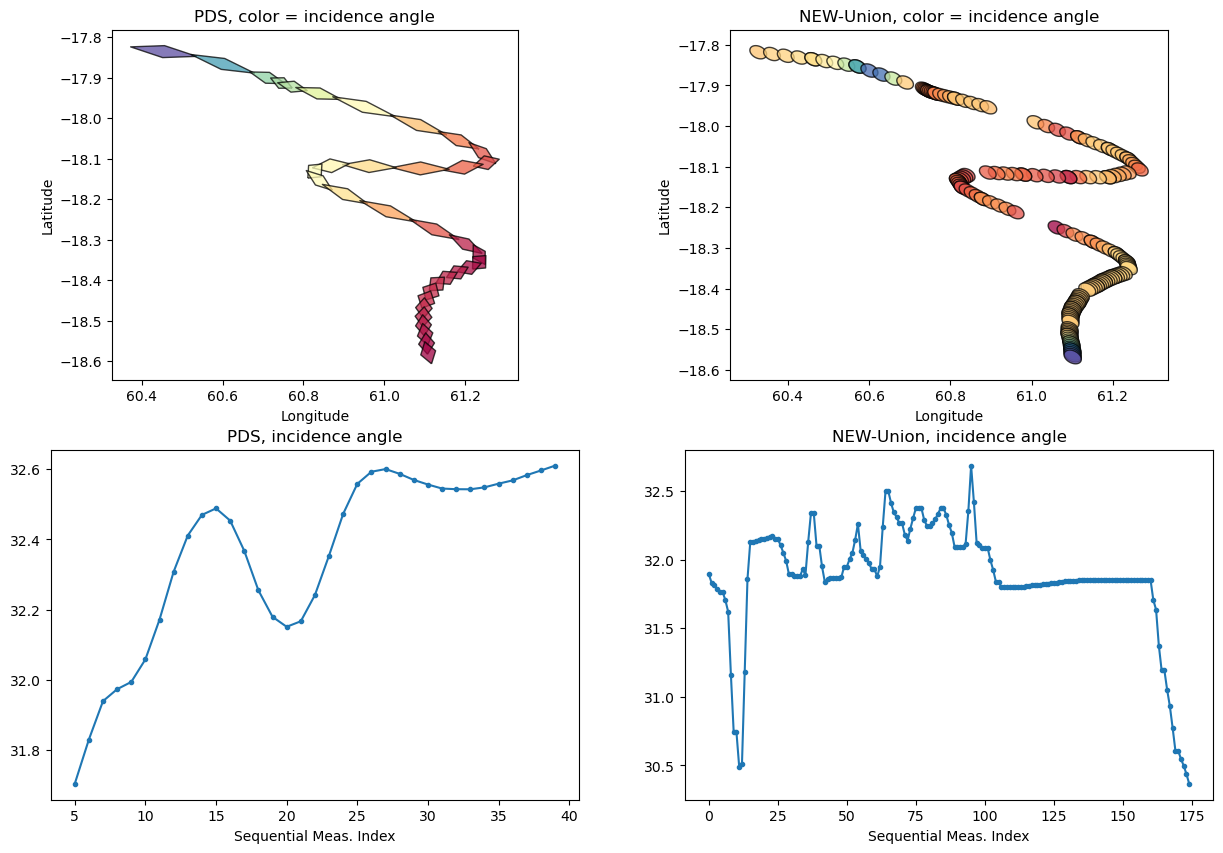

In [159]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=[15,10])
axs = axs.flatten()

gdf_pds_poly.set_index('pid').loc[geounion_gdf.pid].plot(ax=axs[0],column='INCIDENCE_ANGLE',edgecolor='black',cmap=plt.cm.Spectral_r,alpha=0.75)
axs[0].set_title('PDS, color = incidence angle');

gdf_pds_poly.set_index('pid').loc[geounion_gdf.pid]['INCIDENCE_ANGLE'].plot(marker='.',ax=axs[2])
axs[2].set_title('PDS, incidence angle');


geofovs_df.plot(ax=axs[1],column='mean_incdnc',edgecolor='black',cmap=plt.cm.Spectral_r,alpha=0.75)
axs[1].set_title('NEW-Union, color = incidence angle');

geofovs_df['mean_incdnc'].plot(marker='.',ax=axs[3])
axs[3].set_title('NEW-Union, incidence angle');

_ = [a.set_xlabel('Sequential Meas. Index') for a in axs[-2:]]
_ = [(a.set_xlabel('Longitude'),a.set_ylabel('Latitude')) for a in axs[:2]]


## Save output to csv , geojson, shapefiles etc


Set `output` to a path and then run 

In [ ]:
output = pathlib.Path('/tmp/')

In [ ]:
gdf_pds_poly.to_csv( output / 'NEW-iFOV.csv.zip')

geounion_gdf.to_wkt().rename(columns={'geometry':'fov'}).to_csv( output / 'NEW-FOV-union-convex.csv.zip')

In [ ]:
#  if yu wish, change the driver to shapefile 
gdf_pds_poly.to_file(output / 'NEW-iFOV.geojson', driver="GeoJSON")
geounion_gdf.to_file(output / 'NEW-FOV-union-convex.geojson', driver="GeoJSON")